<a href="https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7/blob/alyhakim/Tweet_Sentiment_Extraction_HTK_Report_23_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 7:
1. 18120429 – Phạm Trung Kiên - trungkien2000
2. 18120431 – A Ly Ha Kim - kim-ali
3. 18120434 – Thái Hoàng Lâm - hoanglam372000
4. 18120462 – Nguyễn Thị Mận - ManCB26
Link thùng chứa Github của nhóm:
https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7

# I. Mô tả bài toán: 
## 1. Mô tả:
Link: https://www.kaggle.com/c/tweet-sentiment-extraction \

- Bài toán thuộc lĩnh vực NLP, cụ thể là bài toán phân tích cảm xúc (Sentiment Analysis)
- Không giống như những bài toán phân tích cảm xúc khác chỉ dừng ở việc phân lớp, bài toán yêu cầu phải rút trích những từ ngữ trong câu đóng góp cho cảm xúc tương ứng.
- Ví dụ: "I am happy": positive -> "happy" \

## 2. Hướng giải quyết của nhóm 
Ban đầu nhóm định theo hướng giải quyết của người đứng hạng 3 trên private leaderboard, đó là sử dụng RoBerta. Tuy nhiên, với trình độ hiện tại của các bạn trong nhóm thì phương pháp này đang vượt quá tầm với vì vậy phương hướng tiếp cận của nhóm đã vẽ ra như sau:

- Nhóm tiến hành giải bài toán theo cách riêng của nhóm: Học thống kê \
- Sau khi ra kết quả training, nếu chưa đạt được kết quả nằm trong top 20 của private leaderboard, thì nhóm sẽ tiếp tục tiếp cận dần các phương pháp Deep learning \
- Sau cùng, nếu vẫn chưa đạt được kết quả khả quan với những kiến thức deep learning đã học, nhóm sẽ tiến hành giải tiếp bài toán theo phương pháp của hạng 3 (lúc này các thành viên đã đủ kiến thức)




# II. Giải quyết bài toán và cài đặt:

# 1. Học dựa trên thống kê

- Tiền xử lý và khám phá dữ liệu
- Xây dựng từ điển tần suất theo sentiment
- Xây dựng Bag-of-word theo xác suất Naive-Bayes
- Trích text bằng likelihood của bước trên và ước lượng ngưỡng
- Ánh xạ text đã rút trích về nguyên mẫu của từng từ trong text (đề yêu cầu)
- Đánh giá bằng độ đo Jaccard Similarity
- Tunning trên tập val để tìm siêu tham số tốt nhất
- Dự đoán rút trích trên tập test
 

### 1.1 Lấy dữ liệu, Khám phá và tiền xử lý:

#### 1.1.1 Thư viện:

In [ ]:
!git clone https://github.com/hoanglam372000/Applied-Data-Science-Group-7.git

Cloning into 'Applied-Data-Science-Group-7'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 105 (delta 55), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (105/105), 2.04 MiB | 4.45 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
!pip install emoji
!pip install pyenchant
#!pip install pycontractions

     |████████████████████████████████| 170 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=7c7ba8ed99145be42d32e36424b8c521968d3a0678a539e80fce093818771fa2
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
     |████████████████████████████████| 55 kB 1.7 MB/s 


In [ ]:
import math
import pandas as pd
import nltk
import numpy as np
import emoji
#import contractions
import re

import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
import scipy.stats as st
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint
#print(stopwords.words('english'))
pd.set_option('display.max_colwidth', 200)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('names')
names = nltk.corpus.names.words('male.txt')+nltk.corpus.names.words('female.txt')
names_lower = [name.lower() for name in names]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


#### 1.1.2 Khám phá dữ liệu

In [ ]:
df = pd.read_csv('Applied-Data-Science-Group-7/train.csv')

In [ ]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


#### 1.1.3 Tách tập dữ liệu

In [ ]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 70%:30%
X_df = df.drop(labels = 'selected_text',axis = 1)
y_ex = df.selected_text
y_class = df.sentiment
train_X_df, val_X_df, train_y_ex, val_y_ex = train_test_split(X_df, y_ex, test_size=0.3, 
                                                              stratify=y_class, random_state=0)

In [ ]:
print('train_X: ',train_X_df.shape)
print('train_y: ',train_y_ex.shape)
print('val_X: ',val_X_df.shape)
print('val_y: ',val_y_ex.shape)


train_X:  (19236, 3)
train_y:  (19236,)
val_X:  (8244, 3)
val_y:  (8244,)


### 1.2 Tiền xử lý + Khám phá tập train

#### 1.2.1 Khám phá tập train

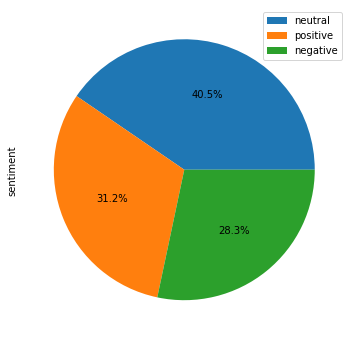

In [ ]:
#Phân bố của các lớp:
train_X_df.sentiment.value_counts(normalize= True).plot(kind="pie",labels = None, legend='auto', figsize=(8,6), autopct="%.1f%%");

In [ ]:
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19236 entries, 652 to 12238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     19236 non-null  object
 1   text       19236 non-null  object
 2   sentiment  19236 non-null  object
dtypes: object(3)
memory usage: 601.1+ KB


In [ ]:
train_X_df.duplicated().sum()

0

In [ ]:
train_y_ex.isnull().sum()

0

#### 1.2.2 Tiền xử lý văn bản

In [ ]:
 nltk.pos_tag(['i','am','over','the','moon'])

[('i', 'NN'), ('am', 'VBP'), ('over', 'IN'), ('the', 'DT'), ('moon', 'NN')]

In [ ]:
# import enchant
# from nltk.metrics import edit_distance
# class SpellingReplacer(object):
#     def __init__(self, dict_name='en', max_dist=2):
#         self.spell_dict = enchant.Dict(dict_name)
#         self.max_dist = max_dist
#     def replace(self, word):
#         if self.spell_dict.check(word):
#             return word
#         suggestions = self.spell_dict.suggest(word)
#         if suggestions and edit_distance(word, suggestions[0]) <=self.max_dist:
#             return suggestions[0]
#         else:
#             return word
# replacer = SpellingReplacer()
# replacer.replace('cookbok')

In [ ]:
stemmer = PorterStemmer()

class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
    def replace(self, word):
        if wordnet.synsets(word):
            return word
        repl_word = self.repeat_regexp.sub(self.repl, word)
        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word
char_repeat_correct = RepeatReplacer()
def preprocessing_word(word):
  
  if word != emoji.demojize(word):
    return emoji.demojize(word)
  #word = contractions.fix(word)
  #word = stemmer.stem(word)
  
  temp=[ "<html_tag>",'<URL>','<HIDDEN>','<tag>',"<hash_tag>"]
  if word in temp:
    return word
  #số theo từ
  if word.isdigit():  
    return '<NUMBER>'
  try: 
    float(word)
    return '<NUMBER>'
  except:
    pass


  #word=word.lower() # viết thườngthường
  #spell_corrector = Speller(lang='en') #sửa chính tả theo từng từ 
  #word=spell_corrector(word)

  # rút gọn theo từ
  #lemmatizer = WordNetLemmatizer()
  #wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
  #pos_tagged = nltk.pos_tag(word.split())
  
  #word = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged]
  #word = ' '.join(word)

  #word=word.translate(str.maketrans('', '', string.punctuation)) # chấm câu theo từ (vì tránh emoij)
  word = re.sub(pattern=r'[!"#$%&\'()*+,-\./:;<=>?@\[\]^_`{|}~0-9ï¿½]+', repl='', string=word)
  word = char_repeat_correct.replace(word)
  word = stemmer.stem(word)
  if (word in  names):
    return '<Name>'
  #word = stemmer.stem(word)
  word = word.lower()
  
  if word==''or word ==' ':
    return "<Special_Character>"
  
  if 'not' not in word and len(word.split())!=1:
    return word.split()[0]+'_'
  return word.replace(' ','_')

def preprocessing_text(tweet,sentiment):
   raw_text = str(tweet).strip().replace('\n', ' ')#.lower()
   # emoij
   raw_text=emoji.demojize(raw_text)
   e_r=r':\w+_\w+:'
   emoij_list=re.findall(e_r,raw_text)
   for e in emoij_list:
     raw_text=raw_text.replace(e,' ' + emoji.emojize(e) + ' ') # "hi❤️👍"
   if sentiment !=0: 
     raw_text = re.sub(pattern=r'(?<=\w)(\.){2,}?(?=\w)', repl=' ', string=raw_text)
   new_tweet = raw_text.split()
   len_=len(new_tweet)
   index2word = { w:new_tweet[w] for w in range(len_)}
   #parser = BeautifulSoup(raw_text, "html.parser")
   #raw_text = parser.get_text(separator = "<html_tag>")
   raw_text = re.sub(pattern=r'https?://\S+|www\.\S+', repl='<URL>', string=raw_text)
   raw_text = re.sub(pattern='\*{3,}?', repl='<HIDDEN>', string=raw_text)
   raw_text = re.sub(pattern=r'@\w+', repl='<tag>', string=raw_text)
   raw_text = re.sub(pattern=r'#\w+', repl='<hash_tag>', string=raw_text)
   
   word_list=raw_text.split()
   return index2word,dict(zip([*range(len_)],map(preprocessing_word,word_list)))

In [ ]:
# Test:
tweet = ' My mom just texted.......me and told *ship* James that Rodney3 charlie wasï¿½ *** chasing?? and fireflies... in their :)) backyard. Awwwww I`m miss him!!! @hoanglam 123 ://    http://twitpic.com/66pn1'
tweet2 = 'their :)) <3'
index2word_temp,preprocessed_tweet_temp = preprocessing_text(tweet,1)
print('index2word: ',index2word_temp)
print('preprocessed_tweet: ',preprocessed_tweet_temp)

index2word:  {0: 'My', 1: 'mom', 2: 'just', 3: 'texted', 4: 'me', 5: 'and', 6: 'told', 7: '*ship*', 8: 'James', 9: 'that', 10: 'Rodney3', 11: 'charlie', 12: 'wasï¿½', 13: '***', 14: 'chasing??', 15: 'and', 16: 'fireflies...', 17: 'in', 18: 'their', 19: ':))', 20: 'backyard.', 21: 'Awwwww', 22: 'I`m', 23: 'miss', 24: 'him!!!', 25: '@hoanglam', 26: '123', 27: '://', 28: 'http://twitpic.com/66pn1'}
preprocessed_tweet:  {0: 'my', 1: 'mom', 2: 'just', 3: 'text', 4: 'me', 5: 'and', 6: 'told', 7: 'ship', 8: 'jame', 9: 'that', 10: 'rodney', 11: 'charli', 12: 'wa', 13: '<HIDDEN>', 14: 'chase', 15: 'and', 16: 'firefli', 17: 'in', 18: 'their', 19: '<Special_Character>', 20: 'backyard', 21: 'aw', 22: 'im', 23: 'miss', 24: 'him', 25: '<tag>', 26: '<NUMBER>', 27: '<Special_Character>', 28: '<URL>'}


In [ ]:
char_repeat_correct.replace(':))))))')

':))))))'

In [ ]:

def preprocess_tweets(X_df):
  X_df = X_df.copy()
  raw_tweets = X_df.text.to_list()
  X_df.sentiment = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1})
  index2word_tweets = [] #list of dictionaries
  preprocessed_tweets = [] #list of dictionaries
  cleaned_texts = []
  for tweet,senti in zip(raw_tweets,X_df.sentiment.to_list()):
    index2word, preprocessed = preprocessing_text(tweet,senti)
    index2word_tweets.append(index2word)
    preprocessed_tweets.append(preprocessed)
    cleaned_texts.append(' '.join(list(preprocessed.values())))
  preprocessed_X_df = pd.DataFrame(data={'textID':X_df.textID,'index2word':index2word_tweets, 'preprocessed_texts':preprocessed_tweets,'sentiment':X_df.sentiment})
  cleaned_int2text_df = pd.DataFrame(data={'textID':X_df.textID,'Raw_text':X_df.text, 'Cleaned_texts':cleaned_texts,'sentiment':X_df.sentiment})
  return preprocessed_X_df,cleaned_int2text_df

def _preprocessed_y_ex(X_df,y_ex):
  preprocessed_y_ex = []
  X_df = X_df.copy()
  for tweet,senti in zip(y_ex.to_list(),X_df.sentiment.to_list()):
      index2word, preprocessed_y = preprocessing_text(tweet,senti)
      preprocessed_y_ex.append(preprocessed_y)
  X_df['sentiment'] = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1}).to_list()
  return pd.DataFrame(data = {'preprocessed_texts': preprocessed_y_ex,'sentiment':X_df.sentiment})



In [ ]:
train_X_df.head(5)

,textID,text,sentiment
652,a834cef9c6,1st presentation for senior boards? FML,negative
24883,5bfad683d5,yummy curry save me some please lol,positive
15385,08a8d660b1,I wish I knew someone down there who could hook us up. a friend told me once that they got crappy seats for a show in CHI,negative
16753,99a0ff3bef,Lucky u Im stuck in the rain...,neutral
19,40e7becabf,Hes just not that into you,neutral


In [ ]:
#_preprocessed_y_ex(train_X_df.head(100),train_y_ex.head(100))

In [ ]:
# Test:
preprocessed_X_df_temp,cleaned_int2text_df_temp = preprocess_tweets(train_X_df.head(100))
cleaned_int2text_df_temp

,textID,Raw_text,Cleaned_texts,sentiment
652,a834cef9c6,1st presentation for senior boards? FML,st present for senior board fml,-1
24883,5bfad683d5,yummy curry save me some please lol,yummi curri save me some pleas lol,1
15385,08a8d660b1,I wish I knew someone down there who could hook us up. a friend told me once that they got crappy seats for a show in CHI,i wish i knew someon down there who could hook us up a friend told me onc that they got crappi seat for a show in chi,-1
16753,99a0ff3bef,Lucky u Im stuck in the rain...,lucki u im stuck in the rain,0
19,40e7becabf,Hes just not that into you,he just not that into you,0
...,...,...,...,...
16799,82d211bdd5,i think i hate you. i didnt really want to but you make it hard for me to like you what with the cake and concert on the ...,i think i hate you i didnt realli want to but you make it hard for me to like you what with the cake and concert on the <Special_Character>,-1
6706,7a775cc933,If I were a transformer... I`d step on people just to hear them *squoosh*. But I`m not so I guess I`ll just have a cup of coffee instead.,if i were a transform id step on peopl just to hear them squosh but im not so i guess ill just have a cup of coffe instead,0
1967,127ac4d1d2,ohay clean teeth,ohay clean teeth,1
9181,4b8cb4449b,Im fine also..up way to early..lol...soo those r all ur dogs? to kut3 ..i def want a pit! lol,im fine alsoup way to earlylolso those r all ur dog to kut i def want a pit lol,0


### 2. Mô hình hoá dữ liệu:

In [ ]:
preprocessed_train_X, cleaned_train_X = preprocess_tweets(train_X_df)
preprocessed_train_y_ex = _preprocessed_y_ex(train_X_df,train_y_ex)
preprocessed_val_X, cleaned_val_X = preprocess_tweets(val_X_df)
preprocessed_val_y_ex = _preprocessed_y_ex(val_X_df,val_y_ex)

In [ ]:
#cleaned_train_X

In [ ]:
#pd.set_option('display.max_rows', df.shape[0]+1)
visual_df = pd.DataFrame(data ={'text':preprocessed_train_X.preprocessed_texts,'selected_text':preprocessed_train_y_ex.preprocessed_texts,'sentiment':preprocessed_train_X.sentiment})
visual_df.head(10)

,text,selected_text,sentiment
652,"{0: 'st', 1: 'present', 2: 'for', 3: 'senior', 4: 'board', 5: 'fml'}",{0: 'fml'},-1
24883,"{0: 'yummi', 1: 'curri', 2: 'save', 3: 'me', 4: 'some', 5: 'pleas', 6: 'lol'}",{0: 'yummi'},1
15385,"{0: 'i', 1: 'wish', 2: 'i', 3: 'knew', 4: 'someon', 5: 'down', 6: 'there', 7: 'who', 8: 'could', 9: 'hook', 10: 'us', 11: 'up', 12: 'a', 13: 'friend', 14: 'told', 15: 'me', 16: 'onc', 17: 'that', ...","{0: 'p', 1: 'a', 2: 'friend', 3: 'told', 4: 'me', 5: 'onc', 6: 'that', 7: 'they', 8: 'got', 9: 'crappi', 10: 'seat', 11: 'for', 12: 'a', 13: 'show', 14: 'in'}",-1
16753,"{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}","{0: 'lucki', 1: 'u', 2: 'im', 3: 'stuck', 4: 'in', 5: 'the', 6: 'rain'}",0
19,"{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}","{0: 'he', 1: 'just', 2: 'not', 3: 'that', 4: 'into', 5: 'you'}",0
23126,"{0: 'gah', 1: '<Special_Character>', 2: 'thi', 3: 'weather', 4: 'sucksss', 5: '<Special_Character>'}","{0: 'gah', 1: '<Special_Character>', 2: 'thi', 3: 'weather', 4: 'sucksss', 5: '<Special_Character>'}",-1
27051,"{0: 'apolog', 1: 'dont', 2: 'fix', 3: 'hurt', 4: 'feel', 5: 'kev', 6: 'anyway', 7: 'ill', 8: 'get', 9: 'it', 10: 'from', 11: 'u', 12: 'next', 13: 'time', 14: 'i', 15: 'c', 16: 'u'}","{0: 'apolog', 1: 'dont', 2: 'fix', 3: 'hurt', 4: 'feel', 5: 'kev'}",-1
11314,"{0: '<Special_Character>', 1: 'follow', 2: 'my', 3: 'girl', 4: 'meagan'}","{0: '<Special_Character>', 1: 'follow', 2: 'my', 3: 'girl', 4: 'meagan'}",0
5854,"{0: 'thi', 1: 'is', 2: 'realli', 3: 'help', 4: 'you', 5: 'swear', 6: 'a', 7: 'lot', 8: 'i', 9: 'just', 10: 'realiz', 11: 'haha'}",{0: 'help'},1
8160,"{0: 'happi', 1: 'mother', 2: 'day', 3: 'x', 4: 'mum', 5: 'i', 6: 'love', 7: 'you'}",{0: 'happi'},1


In [ ]:
# pd.set_option('display.max_rows', df.shape[0]+1)
# neutral_df = visual_df.loc[visual_df.sentiment ==1,:]
#neutral_df
# len_neutral_df = neutral_df.loc[:,['text','selected_text']].applymap(len)
# index_neutral_diff = len_neutral_df.loc[len_neutral_df.text != len_neutral_df.selected_text,:]
# #cleaned_train_X.loc[index_neutral_diff.index,:]
# pd.DataFrame(data ={'origin':cleaned_train_X.Raw_text,'text':cleaned_train_X.Cleaned_texts,'selected_text':preprocessed_train_y_ex.preprocessed_texts}).loc[index_neutral_diff.index,:]

In [ ]:
# pos_visual_df = visual_df.loc[visual_df.sentiment == 1,:]
# pos_visual_df.text.apply(len).max()

#### 2.2 Viết class và tinh chỉnh mô hình

In [ ]:
class bayes_extraction(BaseEstimator, TransformerMixin):
    def __init__(self, k = 5,z_neg=1.65,z_neu = 1.65,z_pos=1.65,w =1, vob_threshold = 3):
        #self.num_top_titles = num_top_titles
        self.k = k
        self.z_neg = z_neg
        self.z_neu = z_neu
        self.z_pos = z_pos
        self.vob_threshold = vob_threshold
        self.w = w
    def word2freqs(self,preprocessed_X):
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        list_of_tweets = [list(text.values()) for text in preprocessed_tweets ]
        vob2freq = {}
        for tw in list_of_tweets:
            for word in tw:
              if vob2freq.get(word,0) !=0:
                  vob2freq[word] +=1
              else:
                  vob2freq[word] = 1
        return vob2freq
    def count_tweets(self,preprocessed_X):
        '''
          Input:
      
            tweets: a list of tweets
            ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
          Output:
              result: a dictionary mapping each pair to its frequency
        '''
        preprocessed_X = preprocessed_X.copy()
        y_s = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        processed_tweets = [list(text.values()) for text in preprocessed_tweets ]


        vob2freqs = self.word2freqs(preprocessed_X)
        freqs = {}

        for y, tweet in zip(y_s, processed_tweets):
            for word in tweet:
                if vob2freqs[word] < self.vob_threshold:
                    pair = ('<OOV>',y)
                else:

                    # define the key, which is the word and label tuple
                    pair = (word,y)

              # if the key exists in the dictionary, increment the count
                if pair in freqs:
                    freqs[pair] += 1

              # else, if the key is new, add it to the dictionary and set the count to 1
                else:
                    freqs[pair] = 1

        return freqs

        
    def bayes_likelihood(self,freqs,preprocessed_X):
        '''
          Input:
              freqs: dictionary from (word, label) to how often the word appears
          Output:
              loglikelihood: the log likelihood of you Naive bayes equation.
        '''
        likelihood = {}
        preprocessed_X = preprocessed_X.copy()
        train_y = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        #train_x = [list(text.values()) for text in preprocessed_tweets ]
    

        # calculate V, the number of unique words in the vocabulary
        vocab = set([pair[0] for pair in freqs.keys()])
        vocabs_ = list(vocab)

        V = len(vocab)

        # calculate N_pos and N_neg
        N_pos = N_neg = N_neu = 0
        for pair in freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += freqs[pair]
            elif pair[1] ==0:
                  N_neu += freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += freqs[pair]

          # Calculate D, the number of documents
        D = len(train_y)

        for word in vocab:
          # get the positive and negative frequency of the word
            freq_pos = freqs.get((word,1),0)
            freq_neu = freqs.get((word,0),0)
            freq_neg = freqs.get((word,-1),0)
        

          # calculate the probability that each word is positive, and negative , neutral
            p_w_pos = (freq_pos + self.k) / (N_pos + self.k*V)
            p_w_neu = (freq_neu + self.k) / (N_neu + self.k*V)
            p_w_neg = (freq_neg + self.k) / (N_neg + self.k*V)

          # calculate the log likelihood of the word
            #likelihood[word] = [np.log(p_w_neg),np.log(p_w_neu),np.log(p_w_pos)]
            likelihood[word] = [p_w_neg,p_w_neu,p_w_pos]
        return vocabs_, likelihood

    def lexical_sentiment_score(self,preprocessed_y_ex,x_likelihood):
        y_freqs = self.count_tweets(preprocessed_y_ex) # Dùng làm trọng số rút trích
        #vocabs_,y_likelihood = self.bayes_likelihood(y_freqs,preprocessed_y_ex)
        N_pos = N_neg = N_neu = 0
        for pair in y_freqs.keys():
          # if the label is positive (greater than zero)
            if pair[1] ==1:

                # Increment the number of positive words by the count for this (word, label) pair
                  N_pos += y_freqs[pair]
            elif pair[1] ==0:
                  N_neu += y_freqs[pair]
            # else, the label is negative
            else:
                # increment the number of negative words by the count for this (word,label) pair
                  N_neg += y_freqs[pair]

        new_x_likelihood = x_likelihood.copy()
        for w,l in x_likelihood.items():
            if y_freqs.get((w,-1),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][0]- math.pow(10,-10))) * y_freqs[(w,-1)] )
                new_x_likelihood[w][0] = new_x_likelihood[w][0]*(y_freqs[(w,-1)])*self.w
            if y_freqs.get((w,0),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][1] - math.pow(10,-10)  ))* y_freqs[(w,0)]  )
                new_x_likelihood[w][1] = new_x_likelihood[w][1]*(y_freqs[(w,0)])*self.w
            if y_freqs.get((w,1),0)!=0:
                #new_x_likelihood[w][0] = np.log((1/(-new_x_likelihood[w][2]- math.pow(10,-10))) * y_freqs[(w,1)] )
                new_x_likelihood[w][2] = new_x_likelihood[w][2]*(y_freqs[(w,1)])*self.w
        return new_x_likelihood
           
            
    def Extract_Sentiment_Tweet(self,x_class,tweet):
          '''input:
                tweet: list of word'''
          selected_tweet = []
          s = x_class +1
          if s==1:
            for word in tweet:
              if self.likelihood.get(word,0) !=0:
                    neg_prob,neu_prob,pos_prob = self.likelihood[word]
                    #threshold = 1+self.z_neu
                    if ((neg_prob/neu_prob) < 1 + self.z_neu) or ((pos_prob/neu_prob) < 1+ self.z_neu):
                            selected_tweet.append(word)
              else:
                  selected_tweet.append(word)
          else:
            for word in tweet:
              if self.likelihood.get(word,0) !=0:
                neg_prob,neu_prob,pos_prob = self.likelihood[word]
                max_prob = max(self.likelihood[word])
                if self.likelihood[word].index(max_prob) == s:
                    if abs(max_prob -neu_prob) > self.z_pos:
                    #if max_prob/neu_prob > self.z_pos:
                        selected_tweet.append(word)
                
          return selected_tweet

    # def Extract_Sentiment_Tweet_Log(self,x_class,tweet):
    #     '''input:
    #       tweet: list of word'''
    #     selected_tweet = []
    #     s = x_class +1
    #     if s == 0:
    #       z = self.z_neg
    #     elif s==1:
    #       z = self.z_neu
    #     elif s ==2:
    #       z = self.z_pos
    #     sentiment_score = 0
    #     word_sentiment_score = {}
    #     word_sentiment_percent = {}
    #     for word in tweet:
    #       if self.likelihood.get(word,0)!=0:
    #             word_sentiment_score[word] = self.likelihood[word][s]
    #             sentiment_score += self.likelihood[word][s]
    #     # Tính phần trăm đóng góp sentiment của từng từ trong câu theo tỉ lệ phần trăm:
    #     for w,score in word_sentiment_score.items():
    #         percentage = (abs(score) / abs(sentiment_score))*100
    #         word_sentiment_percent[w] = percentage
    #     #print(word_sentiment_percent)
    #     #threshold = sorted(list(word_sentiment_percent.values()),reverse= True)[0]
    #     #len(list(word_sentiment_percent.values()))
    #     data = np.array(list(word_sentiment_percent.values()))
    #     if data.shape[0] !=0:
    #         threshold = data.mean() + z*(data.std()/math.sqrt(data.shape[0]))
    #     else:
    #         threshold = 0
    #     for w,percent in word_sentiment_percent.items():
    #         if percent < threshold:
    #             selected_tweet.append(w)

    #     return selected_tweet
    
    def Predict_Extract_text(self,Preprocessed_X):
        selected = []
        preprocessed_X = Preprocessed_X.copy()
        y_s = preprocessed_X.sentiment.to_list()
        preprocessed_tweets = preprocessed_X.preprocessed_texts.to_list()
        tweets = [list(text.values()) for text in preprocessed_tweets ]
        for y, tweet in zip(y_s,tweets):
            #selected_predict = Extract_Sentiment_Tweet(y,tweet,likelihood)
            selected_predict = self.Extract_Sentiment_Tweet(y,tweet)
            selected.append(selected_predict)
        return selected
    def Map_Extracted(self,Preprocessed_X,extracted_text):
        # extracted_text = self.Predict_Extract_text(Preprocessed_X)
        index2word = Preprocessed_X.index2word.to_list()
        preprocessed_texts = Preprocessed_X.preprocessed_texts.to_list()
        Selected_text = []
        for e,i,p in zip(extracted_text,index2word,preprocessed_texts):
            Text = {}
            for j in p.items():
              for w in e:
                if w == j[1]:
                  Text[j[0]] = i[j[0]]
          
            Selected_text.append(" ".join(list(Text.values())))
        
        return Selected_text

    def jaccard(self,str1, str2): 
        a = set(str1.lower().split()) 
        b = set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

    def fit(self, preprocessed_X_df, preprocessed_y_ex):
        self.freqs = self.count_tweets(preprocessed_X_df)
        self.vocabs, self.init_likelihood = self.bayes_likelihood(self.freqs,preprocessed_X_df)
        #self.vocabs, self.likelihood = self.bayes_likelihood(self.freqs,preprocessed_X_df)
        self.likelihood = self.lexical_sentiment_score(preprocessed_y_ex,self.init_likelihood)
        return self

    def extract(self, preprocessed_X_df):
        self.extracted_text = self.Predict_Extract_text(preprocessed_X_df)
        selected_text = self.Map_Extracted(preprocessed_X_df,self.extracted_text)
        return selected_text

    def score(self,selected_text,y_ex):
        score = 0
        y_true_s = y_ex.copy().to_list()
        for y_pred, y_true in zip(selected_text,y_true_s):
            score += self.jaccard(str(y_true),y_pred)
        return score/len(y_true_s)

In [ ]:
#tse_st.count_tweets(preprocessed_train_y_ex)

In [ ]:
# Training
tse_st = bayes_extraction(z_pos= 0.00003,z_neu=0.5,vob_threshold=2,k = 10,w=1)
tse_st.fit(preprocessed_train_X,preprocessed_train_y_ex)
selected_train_X = tse_st.extract(preprocessed_train_X)
tse_st.score(selected_train_X,train_y_ex)


0.621737313439751

In [ ]:
#pd.set_option('display.max_rows', df.shape[0]+1)
compare_df = pd.DataFrame(data ={'origin':train_X_df.text,'selected_text':selected_train_X ,'true_text':train_y_ex, 'sentiment':train_X_df.sentiment})
compare_df.loc[compare_df.sentiment == 'positive',:]

,origin,selected_text,true_text,sentiment
24883,yummy curry save me some please lol,yummy curry,yummy,positive
5854,"this is really helpful, you swear a lot, i just realized. haha.","helpful,","helpful,",positive
8160,Happy Mother`s Day x3 ..Mum? I love you,Happy Mother`s Day love,Happy,positive
2514,Is going to sleep. Good night everyone!!,Good everyone!!,Good,positive
17471,"Happy mothers day to all the Twitter moms, sent my own mom a very sleepy video by phone and called after.","Happy mothers day moms, mom very",Happy,positive
2853,http://tr.im/kXCL `Immigrant hid passport in pants` What a genius.,,What a genius.,positive
15830,HAPPY MOTHERS DAY MOMMY!!!!,HAPPY MOTHERS DAY MOMMY!!!!,HAPPY,positive
18263,Tired. About to climb into bed and fall asleep. I hope this weekend will be fun... I only have a couple of weeks left,hope fun...,fun..,positive
6166,so bryan was at the sweet 15 and i didnt think we were gonna talk but towards the end of the night we talked,sweet,sweet,positive
21444,just had an orgasmic sandwich,sandwich,had an orgasmic sandwich,positive


In [ ]:
#tse_st.likelihood['tweepl']

In [ ]:
#pd.DataFrame(data ={'origin':train_X_df.text,'preds':selected_train_X,'selected_text_True':train_y_ex,'sentiment':train_X_df.sentiment})
word2freq = tse_st.word2freqs(preprocessed_train_X)


In [ ]:
word2freq['bestest']

1

In [ ]:
preprocessed_train_X.loc[25753,:]

textID                                                                                                                                                                                                             736c2b7a3e
index2word            {0: 'Home', 1: 'from', 2: 'Disney', 3: 'best', 4: 'time', 5: 'in', 6: 'a', 7: 'long', 8: 'time', 9: 'howl', 10: 'at', 11: 'the', 12: 'moon', 13: 'tonight', 14: 'for', 15: 'GBA', 16: 'and', 17: 'th...
preprocessed_texts    {0: 'home', 1: 'from', 2: 'disney', 3: 'best', 4: 'time', 5: 'in', 6: 'a', 7: 'long', 8: 'time', 9: 'howl', 10: 'at', 11: 'the', 12: 'moon', 13: 'tonight', 14: 'for', 15: 'gba', 16: 'and', 17: 'th...
sentiment                                                                                                                                                                                                                   1
Name: 25753, dtype: object

In [ ]:
compare_df.loc[25753,:]

selected_text        best
true_text            best
sentiment        positive
Name: 25753, dtype: object

In [ ]:
# Test on val
selected_val_X = tse_st.extract(preprocessed_val_X)
tse_st.score(selected_val_X,val_y_ex)

0.6136495169870987

In [ ]:
#tse_st.likelihood['argi']

In [ ]:
len(tse_st.vocabs)

17368

In [ ]:
tse_st.likelihood['crush']

[0.0004941752723414461, 0.0062520339449770946, 0.0040222340158096144]

#### 2.3 Tunning

In [ ]:
# Tunning
#z_pos_s = [0.0001,0.0002,0.00003,0.00006,0.0004]
vob_thresholds = [2,3,4,5,6]
k_s = [1,2,5,7,10,12,15]
Val_score = {}
Train_score = {}

for k in k_s:
    #for z3 in z_pos_s:
    for thres in vob_thresholds:
      #model = bayes_extraction(z_pos=z3,k=k )
      model = bayes_extraction(k=k,vob_threshold = thres,z_pos = 0.00003, z_neu=4 )
      model.fit(preprocessed_train_X,preprocessed_train_y_ex)
      selected_train_text = model.extract(preprocessed_train_X)
      score_train = model.score(selected_train_text,train_y_ex)
      #Train_score[score_train] = (k,z3)
      Train_score[score_train] = (k,thres)
      selected_val_X = model.extract(preprocessed_val_X)
      score_val = model.score(selected_val_X,val_y_ex)
      #Val_score[score_val] = (k,z3)
      Val_score[score_val] = (k,thres)

best_train_score = max(list(Train_score.keys()))
best_val_score = max(list(Val_score.keys()))
best_k,best_z_pos = Val_score[best_val_score]
print('best_train_score: ',best_train_score)
print('best_val_score: ',best_val_score)
print(f'best_k: {best_k} \n nbest_z_pos: {best_z_pos}')
# best_val_score = max(Val_score)
# best_z = z[Val_score.index(best_val_score)]
# print('best_conf: ',best_z)
# print('best_train_score: ',max(Train_score))
# print('best_val_score: ',best_val_score)

best_train_score:  0.6201151534184228
best_val_score:  0.6102680565509876
best_k: 10 
 nbest_z_pos: 2


In [ ]:
#cleaned_train_X

In [ ]:
submission_df = pd.DataFrame(data = {'textID': test_df.textID,'selected_text':pd.Series(preds_extracted_text)})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
submission_df.head(5)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting Good
2,eee518ae67,Recession shame!
3,01082688c6,happy
4,33987a8ee5,


In [ ]:
# y_test = test_df.sentiment.map({'positive':1,'neutral':0,'negative':-1}).to_list()
# tweets_test = test_df.text.to_list()

In [ ]:
#Extract_text(y_test,preprocessing(tweets_test),likelihood)

In [ ]:
# submission = pd.DataFrame(data ={'textID': test_df.textID,'selected_text':pd.Series(extracted_text)})
# predict